# Введение в регрессию 4
Logit, Probit модели, WOE, IV

In [1]:
# Подключим нужные для базовых операций библиотеки
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Подключим пакеты для использования OLS метода и тестов
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Подгрузим полезные функции
from utils import *

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

## 1. Logit модель на симулированных данных
Рассмотрим задачу классификации с бинарным таргетом

In [2]:
# Определим параметры выборки для задачи Logit
# Создадим удобный словарь, чтобы передавать его в функцию
dist_params = dict(

    # Зададим параметры распределения факторов
    x1_mean = 10.0,
    x1_std = 2.0,
    x2_mean = 8.0,
    x2_std = 1.3,
    corr_12 = 0.0,
    
    # Зададим параметры распределения ошибки
    e_mean = 0.0,
    e_std = 10.0,

    # Укажем размер выборки
    N = 2000,

    # Зададим действительные параметры модели
    beta0 = 100.0,
    beta1 = 1.7,
    beta2 = 2.3
)

# Установим стартовую точку для алгоритма генерации случайных чисел
RANDOM_SEED = 42

In [3]:
# Сгенерируем датасет с нормальным распределением в регрессоре
dt_logit = gen_data(y_type='logit', params=dist_params, seed=RANDOM_SEED)

display(dt_logit)

,x1,x2,y,e
0,10.993428,7.820256,0,-8.634936
1,11.295377,9.979939,1,-0.312035
2,9.531693,7.695622,0,0.180169
3,13.158426,8.997665,1,4.726303
4,9.061051,8.705328,0,-13.668584
...,...,...,...,...
1995,6.621634,7.387357,0,1.714693
1996,6.049024,8.976429,1,11.526481
1997,5.869834,8.036995,0,-12.174038
1998,5.844376,7.583613,0,4.679504


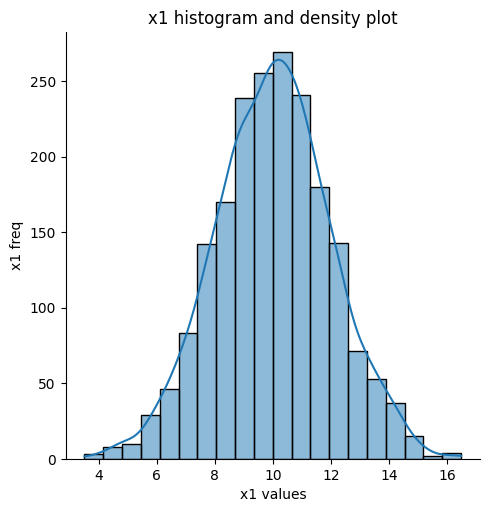

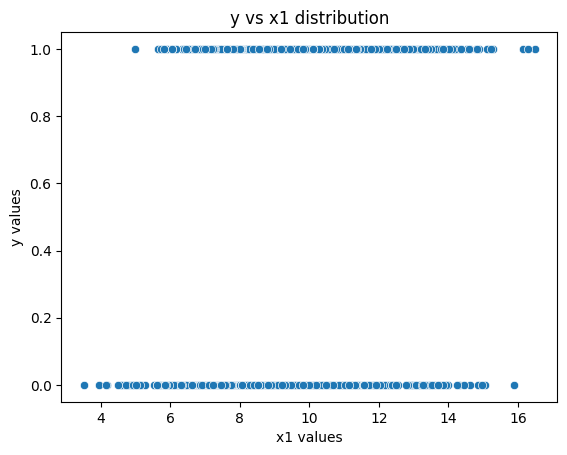

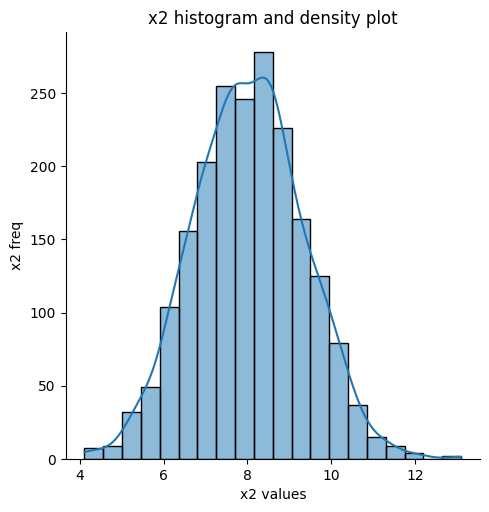

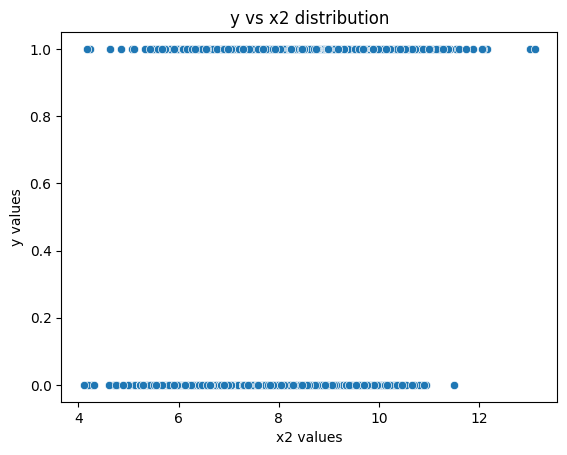

In [4]:
# Отрисуем факторы
plot_data(dt_logit, target='y', feature_names=['x1', 'x2'], plot_type='EDA')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     133.3
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           4.75e-55
Time:                        14:51:34   Log-Likelihood:                -1326.3
No. Observations:                2000   AIC:                             2659.
Df Residuals:                    1997   BIC:                             2675.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8421      0.084    -10.085      0.0

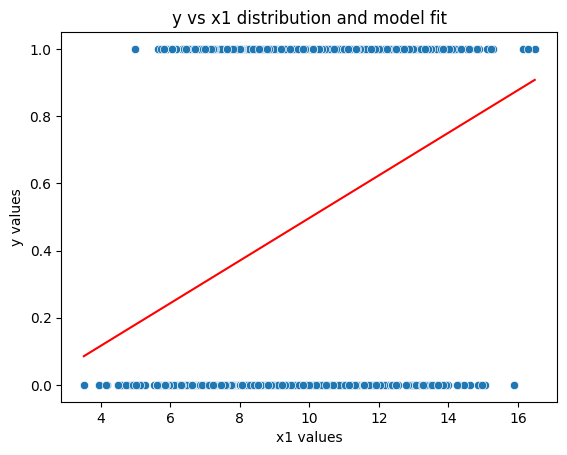

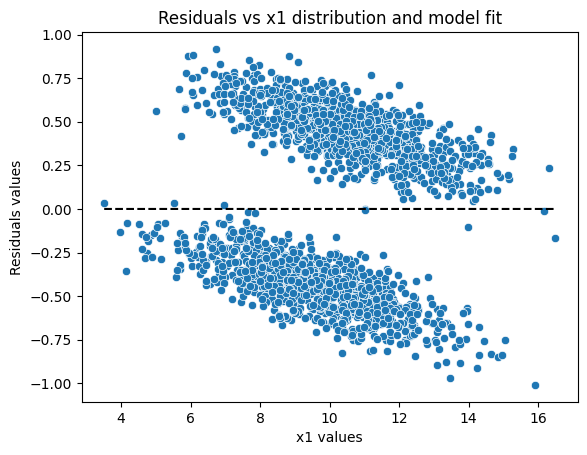

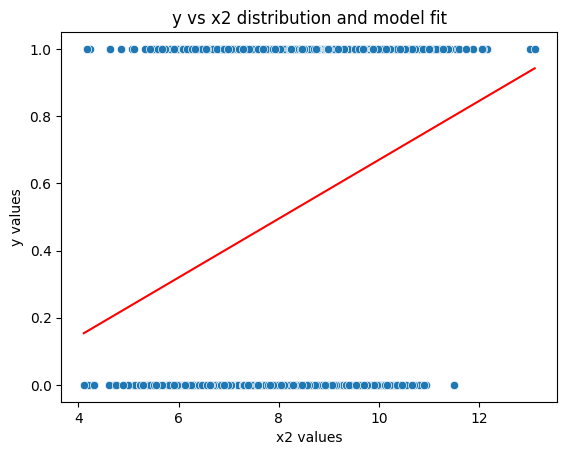

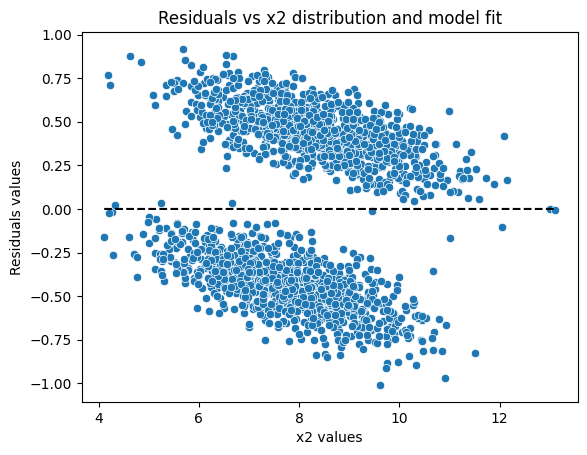

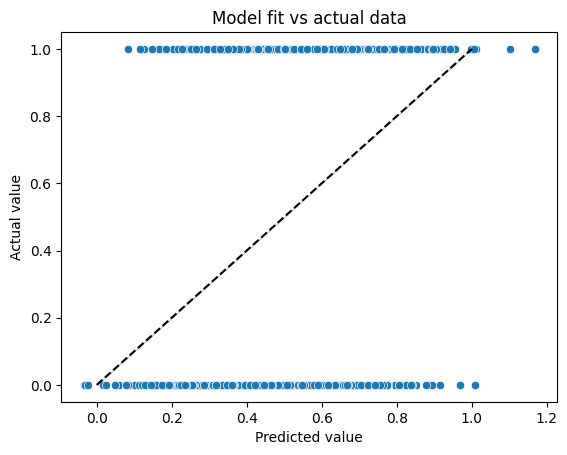

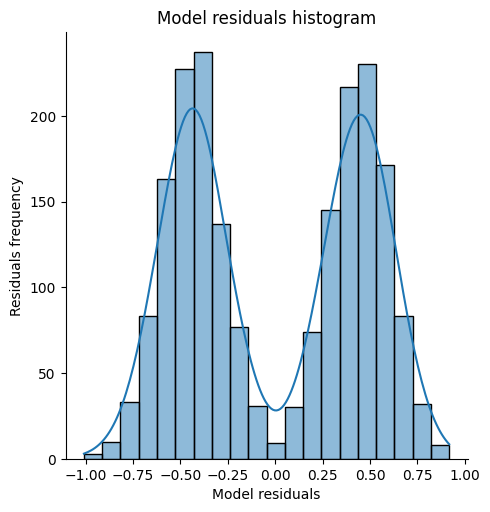

,test,p_level,a_level,a_calc,a_calc >= a_level,statistic,critical_value,statistic < critical_value,conclusion
0,Shapiro-Wilk test,0.95,0.05,0.0,False,0.899305,,,not gaussian distribution
1,Epps-Pulley test,0.95,0.05,-,-,-,-,False,count more than 1000
2,D'Agostino's K-squared test,0.95,0.05,0.0,False,11354.286189,,,not gaussian distribution
3,Anderson-Darling test,0.95,0.05,,,88.143702,0.785,False,not gaussian distribution
4,Kolmogorov–Smirnov test,0.95,0.05,0.0,False,0.149575,,,not gaussian distribution
5,Lilliefors test,0.95,0.05,0.001,False,0.149523,,,not gaussian distribution
6,Cramér–von Mises test,0.95,0.05,0.0,False,16.159818,,,not gaussian distribution
7,Chi-squared test,0.95,0.05,1.0,True,-56294995342131200000.0,,,gaussian distribution
8,Jarque–Bera test,0.95,0.05,0.0,False,202.214419,,,not gaussian distribution
9,skewtest,0.95,0.05,0.990043,True,0.012479,,,gaussian distribution


In [5]:
# Обучим простую Linear Probability Model и выведем результаты
dt_logit, model_logit = train_model(dt_logit, target='y', feature_names=['x1', 'x2'], show_results=True, return_norm_tests=True)

Linear Probability Model нас не устраивает ввиду наличия двух крупных недостатков:
- Предсказанные вероятности могут быть вне интервала [0, 1]
- Постоянный предельный эффект на зависимую переменную. То есть при любом значении 𝑥% производная
является константой, что странно, когда мы говорим о вероятностях

Давайте теперь посмотрим на предсказанные значения склонности положительного исхода у модели типа Logit

Optimization terminated successfully.
         Current function value: 0.630481
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:                 0.09040
Time:                        14:51:37   Log-Likelihood:                -1261.0
converged:                       True   LL-Null:                       -1386.3
Covariance Type:            nonrobust   LLR p-value:                 3.766e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0928      0.426    -14.305      0.000      -6.928      -5.258
x1             0.2874      0.

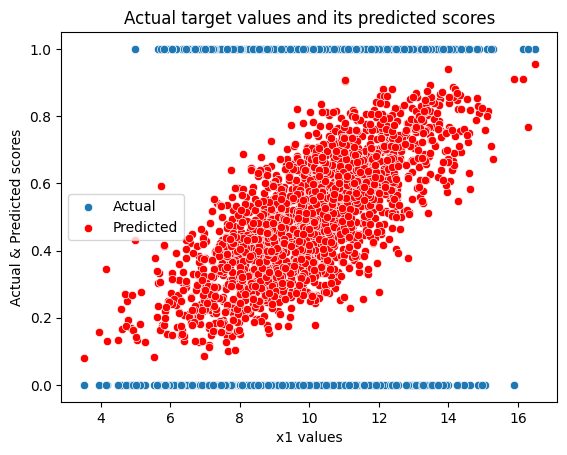

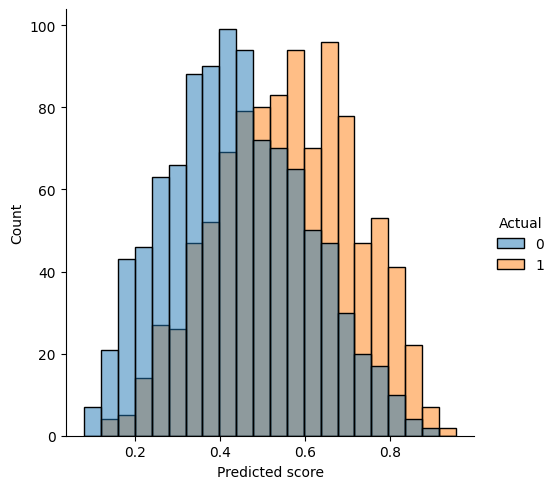

Predicted,0,1
Actual,,
0,663,341
1,363,633


In [6]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, target='y', feature_names=['x1', 'x2'], plot_feature='x1', model_type='logit', pkg='statsmodels')

Выше мы обучили модель логистической регрессии с помощью пакета Statsmodels. Но очень распространенным также является реализация Logit модели в пакете Scikit-learn. Здесь по дефолту используется регуляризация, об этом можно почитать в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
С силой регуляризации можно играться, меняя параметр C, также регуляризацию можно отключить совсем за счет использования настройки penalty='none'. Если на практике встретитесь со случаем, когда результаты двух пакетов расходятся, то обратите внимание на этот параметр.


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.697

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      1004
           1       0.65      0.64      0.64       996

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



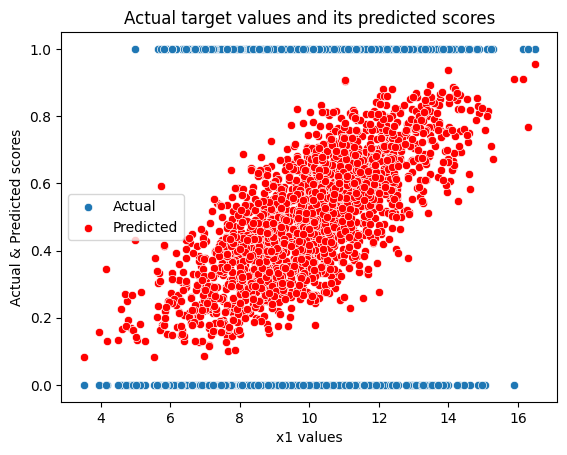

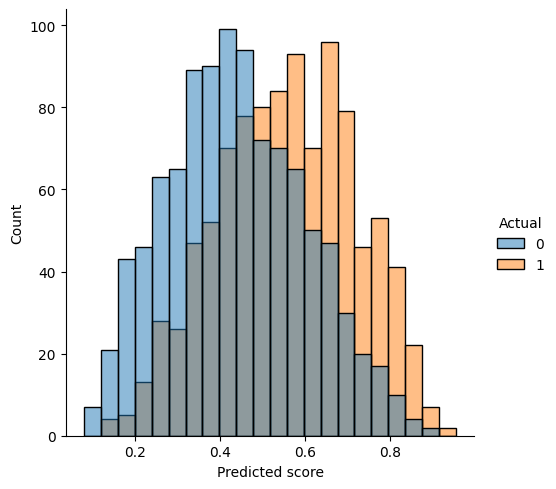

Predicted,0,1
Actual,,
0,663,341
1,363,633


In [8]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(
    dt_logit, target='y', feature_names=['x1', 'x2'],
    plot_feature='x1', model_type='logit', pkg='sklearn')

## 2. Logit модель на датасете [Heart Disease Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset/data)
В данной секции примедена демонстрация применения Logit модели для классификации пациентов на более и менее склонных иметь сердечные заболевания

In [9]:
# Подгрудаем датасет
heart_deaseases_dt = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
display(heart_deaseases_dt)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


Давайте обучим Logit модель на этом датасете. Без валидации, предполагая, что весь датасет - это наш train датасет.
Для демонстрации работы скрипта я буду использовать только первые 5 колонок + Возрастную группу (Age). В домашней работе вам будет необходимо взять все колонки.


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.791

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    229787
         1.0       0.31      0.00      0.00     23893

    accuracy                           0.91    253680
   macro avg       0.61      0.50      0.48    253680
weighted avg       0.85      0.91      0.86    253680



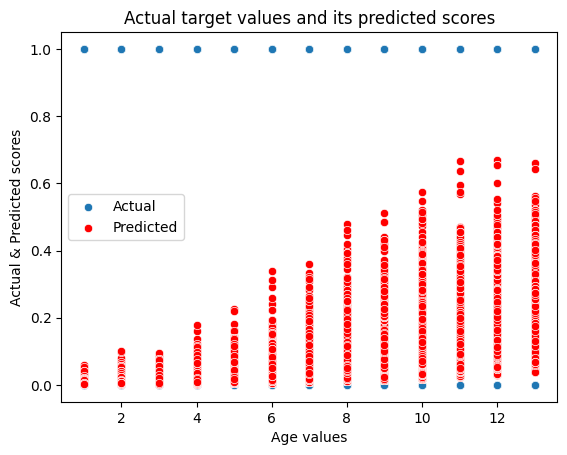

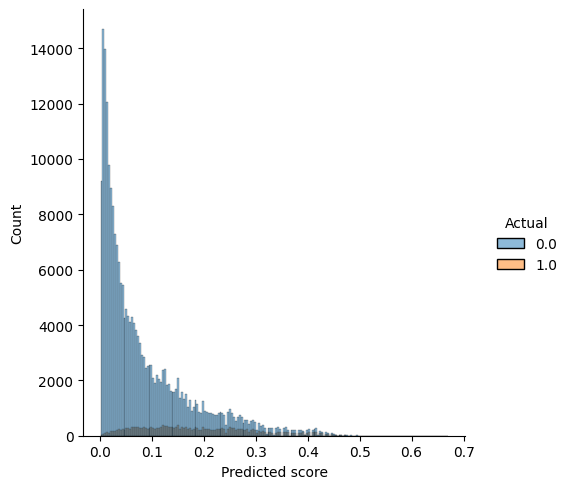

Predicted,0.000000,1.000000
Actual,,
0.000000,229754,33
1.000000,23878,15


In [10]:
# Обучим Logit модель на первых 5 колонках + Age
dt_logit, model_logit = train_binary(
    heart_deaseases_dt, target='HeartDiseaseorAttack',
    feature_names=['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Age'],
    plot_feature='Age',
    model_type='logit', pkg='sklearn')

Можно заметить, что со стандартной отсечкой модель почти не выдает положительный класс в предсказаниях. Это может быть связано с дисбалансом классов, который мы обсудили на лекции. Есть много способов работы с выборками, имеющими дисбаланс, в будущих лекциях вы разберете эти подходы. Сейчас же предлагаю использовать подход изменения веса того или иного наблюдения в функции потерь. 

В sklearn этот подход уже реализован с помощью парамера [class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Наиболее простое решение - взвесить наблюдения обратно-пропорционально доле их класса в выборке: 
> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Давайте используем эту настройку и посмотрим на результаты.



 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.791

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80    229787
         1.0       0.20      0.77      0.32     23893

    accuracy                           0.69    253680
   macro avg       0.58      0.72      0.56    253680
weighted avg       0.89      0.69      0.75    253680



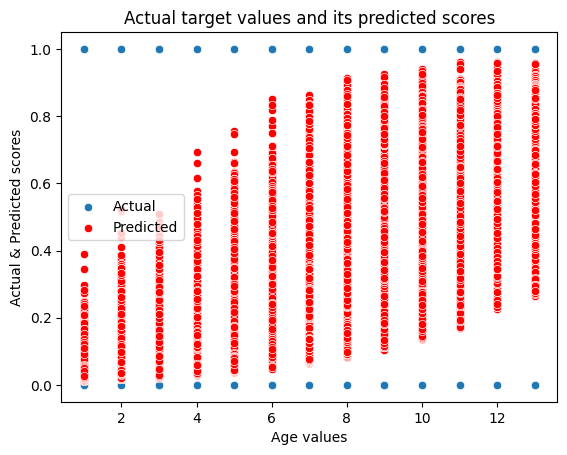

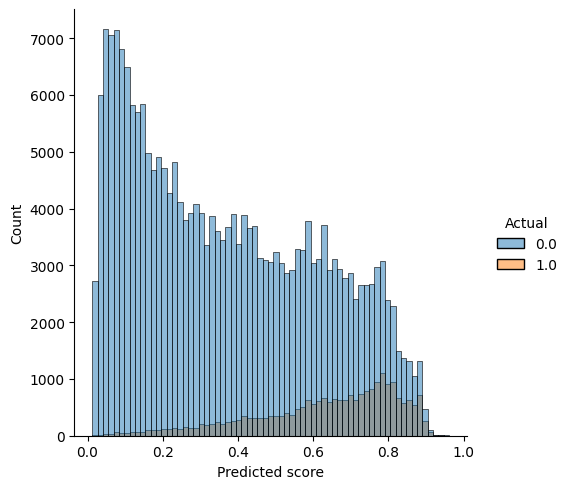

Predicted,0.000000,1.000000
Actual,,
0.000000,155939,73848
1.000000,5578,18315


In [11]:
# Обучим Logit модель на первых 5 колонках + Age
dt_logit, model_logit = train_binary(
    heart_deaseases_dt, target='HeartDiseaseorAttack',
    feature_names=['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Age'],
    plot_feature='Age',
    model_type='logit', pkg='sklearn', class_weight='balanced')

Как видно по результатам, распределения скоров сместились и стало заметно, что плотность скоров у positive класса сместилась вправо - модель стала более жесткой в каком-то плане и начала предсказывать больше positive исходов при отсечке 0.5. По репорту мы видим, что F1-macro вырос с 0.48 до 0.56, делая модель более применимой, чем первая версия, которая попала в ловушку несбалансированных данных и решила предсказывать почти всем наблюдениям наиболее превалирующий класс.